# Association Rule Mining Lab – Apriori and FP-Growth

**Name:** Nicolas Ferradas  
**Course:** MSCS 634 – Advanced Big Data and Data Mining  

## Step 1: Data Preparation

- Import the required Python libraries.
- Load a publicly available transactional dataset.
- Clean and transform the data into a basket format (one row per transaction, one column per item, values 0/1).
- Use Seaborn to explore the dataset with simple visualizations.


In [2]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 11.6 MB/s  0:00:00



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\nicol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# load data
df = pd.read_csv("online_retail.csv", encoding="utf-8", engine="python")
df.columns = df.columns.str.replace('\ufeff', '', regex=True)

print("Shape of raw dataset:", df.shape)
df.head()

Shape of raw dataset: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Basic Data Cleaning

The Online Retail dataset contains invoice-level transactions.  
We will perform a few simple cleaning steps:

- Remove rows with missing `InvoiceNo` or `Description`.
- Remove canceled invoices
- Keep only positive quantities and positive prices.
- Optionally filter to a single country to reduce size and noise.


In [15]:
df_clean = df.dropna(subset=["InvoiceNo", "Description"])

df_clean = df_clean[~df_clean["InvoiceNo"].astype(str).str.startswith("C")]

df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["UnitPrice"] > 0)]

if "Country" in df_clean.columns:
    df_clean = df_clean[df_clean["Country"] == "United Kingdom"]

print("Shape after cleaning:", df_clean.shape)
df_clean.head()


Shape after cleaning: (485123, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Most Frequently Purchased Items

Next, I need to count how often each item `Description` appears and plot the top 20 items.  
This will give us a quick view of which products dominate the transactions.


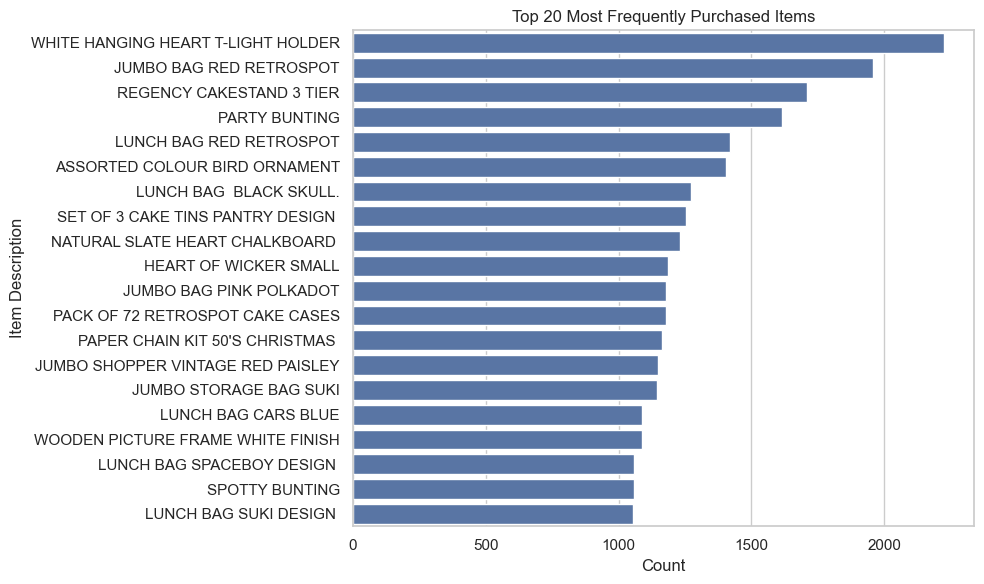

,Description,Count
0,WHITE HANGING HEART T-LIGHT HOLDER,2227
1,JUMBO BAG RED RETROSPOT,1957
2,REGENCY CAKESTAND 3 TIER,1710
3,PARTY BUNTING,1614
4,LUNCH BAG RED RETROSPOT,1421


In [16]:
item_counts = (
    df_clean["Description"]
    .value_counts()
    .reset_index()
)
item_counts.columns = ["Description", "Count"]

top_n = 20
top_items = item_counts.head(top_n)

plt.figure()
sns.barplot(data=top_items, x="Count", y="Description")
plt.title(f"Top {top_n} Most Frequently Purchased Items")
plt.xlabel("Count")
plt.ylabel("Item Description")
plt.tight_layout()
plt.show()

top_items.head()


### Transforming Data into Basket Format

Association rule mining requires data in basket format, where:

- Each row represents a transaction (invoice).
- Each column represents an item.
- Each cell contains 1 if the item appears in the transaction, otherwise 0.

We will:
- Group by `InvoiceNo` and `Description`.
- Create a pivot table where values are 1 if the item is present.
- Use this binary matrix as input for Apriori and FP-Growth.

Then we will create a co-occurrence heatmap for the top 10 items, to see which items tend to appear together.


In [18]:
basket = (df_clean.groupby(["InvoiceNo", "Description"])["Quantity"].sum().unstack().fillna(0))
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)

print("Basket shape:", basket_binary.shape)
basket_binary.head()


Basket shape): (18019, 4007)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


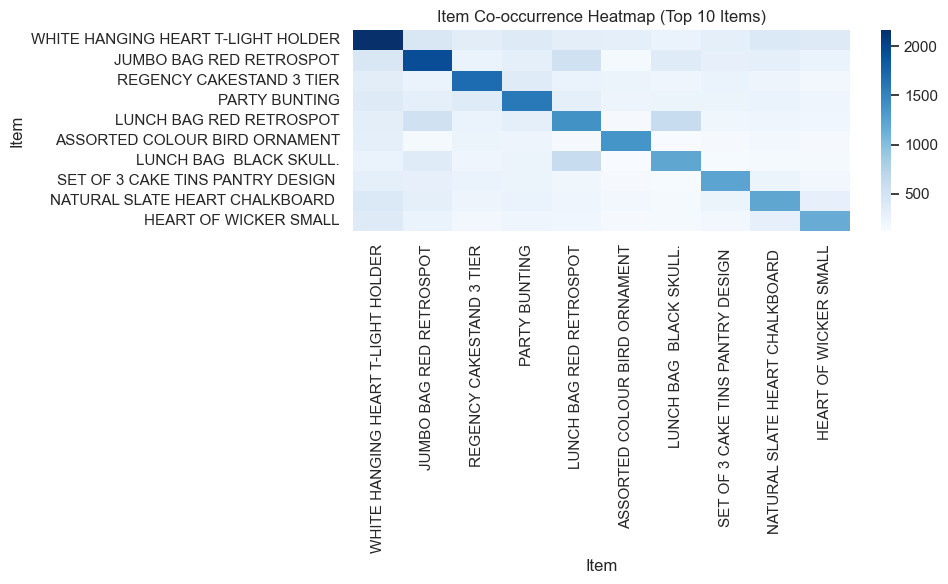

Description,WHITE HANGING HEART T-LIGHT HOLDER,JUMBO BAG RED RETROSPOT,REGENCY CAKESTAND 3 TIER,PARTY BUNTING,LUNCH BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,LUNCH BAG BLACK SKULL.,SET OF 3 CAKE TINS PANTRY DESIGN,NATURAL SLATE HEART CHALKBOARD,HEART OF WICKER SMALL
Description,,,,,,,,,,
WHITE HANGING HEART T-LIGHT HOLDER,2162,436,336,378,324,305,259,310,410,375
JUMBO BAG RED RETROSPOT,436,1935,258,315,531,156,365,289,315,253
REGENCY CAKESTAND 3 TIER,336,258,1685,364,248,239,219,262,224,190
PARTY BUNTING,378,315,364,1593,306,225,246,236,248,207
LUNCH BAG RED RETROSPOT,324,531,248,306,1392,149,607,206,215,192
ASSORTED COLOUR BIRD ORNAMENT,305,156,239,225,149,1371,119,150,175,144
LUNCH BAG BLACK SKULL.,259,365,219,246,607,119,1216,139,158,153
SET OF 3 CAKE TINS PANTRY DESIGN,310,289,262,236,206,150,139,1241,233,188
NATURAL SLATE HEART CHALKBOARD,410,315,224,248,215,175,158,233,1219,291


In [19]:
top10_items = top_items["Description"].head(10).tolist()
basket_top10 = basket_binary[top10_items]

cooccurrence = basket_top10.T.dot(basket_top10)

plt.figure()
sns.heatmap(cooccurrence, annot=False, cmap="Blues")
plt.title("Item Co-occurrence Heatmap (Top 10 Items)")
plt.xlabel("Item")
plt.ylabel("Item")
plt.tight_layout()
plt.show()
cooccurrence

## Step 2: Frequent Itemset Mining Using Apriori

- Apply the Apriori algorithm to the basket data.
- Choose a minimum support threshold (5%) to control how common itemsets must be. The 5% was chosen due to limitations on memory to work with lower percentages. Tries using 2 percent but was running into memory issues
- Display the resulting frequent itemsets and their support.
- Visualize the top frequent itemsets using Seaborn.

In [22]:
min_support_value = 0.05

frequent_itemsets_apriori = apriori(basket_binary, min_support=min_support_value, use_colnames=True)

frequent_itemsets_apriori = frequent_itemsets_apriori.sort_values(by="support", ascending=False).reset_index(drop=True)

print("Number of frequent itemsets found (Apriori):", len(frequent_itemsets_apriori))
frequent_itemsets_apriori.head()

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Number of frequent itemsets found (Apriori): 34


,support,itemsets
0,0.119984,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.107387,(JUMBO BAG RED RETROSPOT)
2,0.093512,(REGENCY CAKESTAND 3 TIER)
3,0.088407,(PARTY BUNTING)
4,0.077252,(LUNCH BAG RED RETROSPOT)


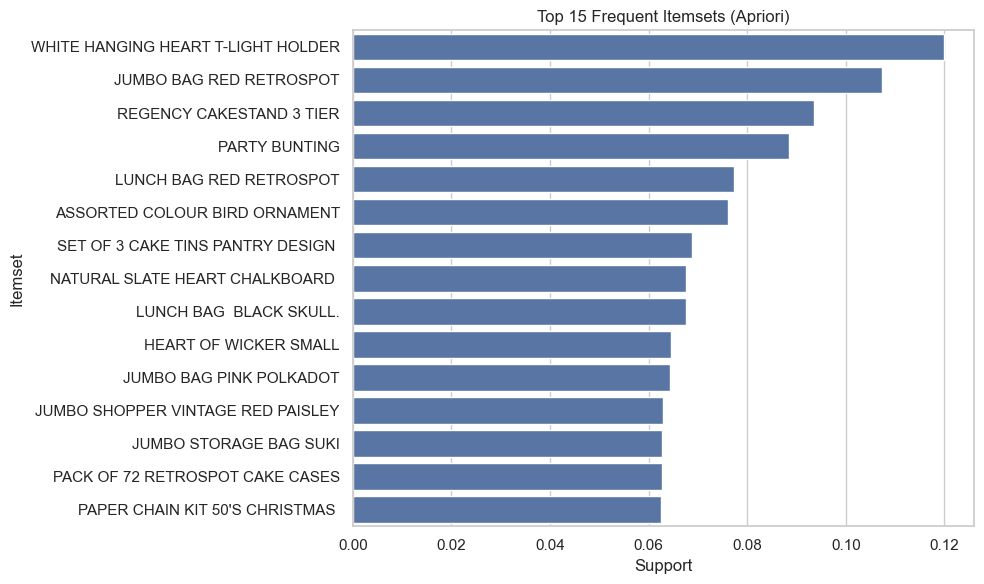

,support,itemsets,itemset_str
0,0.119984,(WHITE HANGING HEART T-LIGHT HOLDER),WHITE HANGING HEART T-LIGHT HOLDER
1,0.107387,(JUMBO BAG RED RETROSPOT),JUMBO BAG RED RETROSPOT
2,0.093512,(REGENCY CAKESTAND 3 TIER),REGENCY CAKESTAND 3 TIER
3,0.088407,(PARTY BUNTING),PARTY BUNTING
4,0.077252,(LUNCH BAG RED RETROSPOT),LUNCH BAG RED RETROSPOT
5,0.076086,(ASSORTED COLOUR BIRD ORNAMENT),ASSORTED COLOUR BIRD ORNAMENT
6,0.068872,(SET OF 3 CAKE TINS PANTRY DESIGN ),SET OF 3 CAKE TINS PANTRY DESIGN
7,0.067651,(NATURAL SLATE HEART CHALKBOARD ),NATURAL SLATE HEART CHALKBOARD
8,0.067484,(LUNCH BAG BLACK SKULL.),LUNCH BAG BLACK SKULL.
9,0.064598,(HEART OF WICKER SMALL),HEART OF WICKER SMALL


In [24]:
frequent_itemsets_apriori["itemset_str"] = frequent_itemsets_apriori["itemsets"].apply(lambda x: ", ".join(list(x)))

top_n_itemsets = 15
top_itemsets_apriori = frequent_itemsets_apriori.head(top_n_itemsets)

plt.figure()
sns.barplot(data=top_itemsets_apriori, x="support", y="itemset_str")
plt.title(f"Top {top_n_itemsets} Frequent Itemsets (Apriori)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

top_itemsets_apriori

## Step 3: Frequent Itemset Mining Using FP-Growth

Now we apply the FP-Growth algorithm on the same basket data:

- Use the same `min_support` as in Apriori to make the comparison fair.
- Compare the number of itemsets and the runtime of both algorithms.
- Visualize the top itemsets from FP-Growth using Seaborn.

FP-Growth is usually faster than Apriori on larger datasets because it avoids generating
a huge number of candidate itemsets explicitly.


In [25]:
import time

start_time = time.time()
_ = apriori(basket_binary, min_support=min_support_value, use_colnames=True)
apriori_time = time.time() - start_time

start_time = time.time()
frequent_itemsets_fpgrowth = fpgrowth(
    basket_binary,
    min_support=min_support_value,
    use_colnames=True
)
fpgrowth_time = time.time() - start_time

frequent_itemsets_fpgrowth = frequent_itemsets_fpgrowth.sort_values(
    by="support", ascending=False
).reset_index(drop=True)

print("Number of frequent itemsets found (FP-Growth):", len(frequent_itemsets_fpgrowth))
print(f"Apriori runtime:   {apriori_time:.4f} seconds")
print(f"FP-Growth runtime: {fpgrowth_time:.4f} seconds")

frequent_itemsets_fpgrowth.head()

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Number of frequent itemsets found (FP-Growth): 34
Apriori runtime:   1.7359 seconds
FP-Growth runtime: 8.9418 seconds


,support,itemsets
0,0.119984,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.107387,(JUMBO BAG RED RETROSPOT)
2,0.093512,(REGENCY CAKESTAND 3 TIER)
3,0.088407,(PARTY BUNTING)
4,0.077252,(LUNCH BAG RED RETROSPOT)


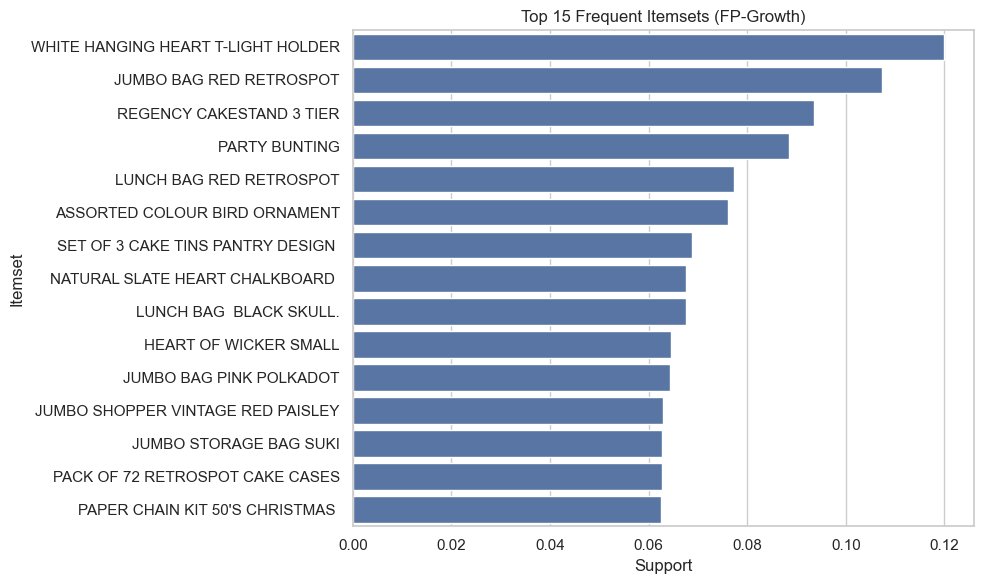

,support,itemsets,itemset_str
0,0.119984,(WHITE HANGING HEART T-LIGHT HOLDER),WHITE HANGING HEART T-LIGHT HOLDER
1,0.107387,(JUMBO BAG RED RETROSPOT),JUMBO BAG RED RETROSPOT
2,0.093512,(REGENCY CAKESTAND 3 TIER),REGENCY CAKESTAND 3 TIER
3,0.088407,(PARTY BUNTING),PARTY BUNTING
4,0.077252,(LUNCH BAG RED RETROSPOT),LUNCH BAG RED RETROSPOT
5,0.076086,(ASSORTED COLOUR BIRD ORNAMENT),ASSORTED COLOUR BIRD ORNAMENT
6,0.068872,(SET OF 3 CAKE TINS PANTRY DESIGN ),SET OF 3 CAKE TINS PANTRY DESIGN
7,0.067651,(NATURAL SLATE HEART CHALKBOARD ),NATURAL SLATE HEART CHALKBOARD
8,0.067484,(LUNCH BAG BLACK SKULL.),LUNCH BAG BLACK SKULL.
9,0.064598,(HEART OF WICKER SMALL),HEART OF WICKER SMALL


In [26]:
frequent_itemsets_fpgrowth["itemset_str"] = frequent_itemsets_fpgrowth["itemsets"].apply(lambda x: ", ".join(list(x)))

top_itemsets_fpgrowth = frequent_itemsets_fpgrowth.head(top_n_itemsets)

plt.figure()
sns.barplot(data=top_itemsets_fpgrowth, x="support", y="itemset_str")
plt.title(f"Top {top_n_itemsets} Frequent Itemsets (FP-Growth)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

top_itemsets_fpgrowth

## Step 4: Generating and Analyzing Association Rules

Using the frequent itemsets, we now generate association rules with the following metrics:
- Support: how often the rule's items appear together in the data.
- Confidence: how often item(s) B appear when A appears.
- Lift: how much more often A and B occur together than expected if they were independent.

Steps:
- Generate rules from Apriori itemsets using a confidence threshold.
- Inspect the top rules by confidence and lift.
- Visualize confidence vs. lift using a scatter plot.


In [41]:
min_confidence_value = 0.3

rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=min_confidence_value)

print("Number of rules generated (Apriori itemsets):", len(rules_apriori))

rules_apriori = rules_apriori.sort_values(by=["confidence", "lift"],ascending=False).reset_index(drop=True)

rules_apriori.head()

Number of rules generated (Apriori itemsets): 0


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


In [36]:
rules_apriori["antecedents_str"] = rules_apriori["antecedents"].apply(lambda x: ", ".join(list(x)))
rules_apriori["consequents_str"] = rules_apriori["consequents"].apply(lambda x: ", ".join(list(x)))

top_rules_apriori = rules_apriori.head(10)
top_rules_apriori[["antecedents_str", "consequents_str", "support", "confidence", "lift"]]

,antecedents_str,consequents_str,support,confidence,lift


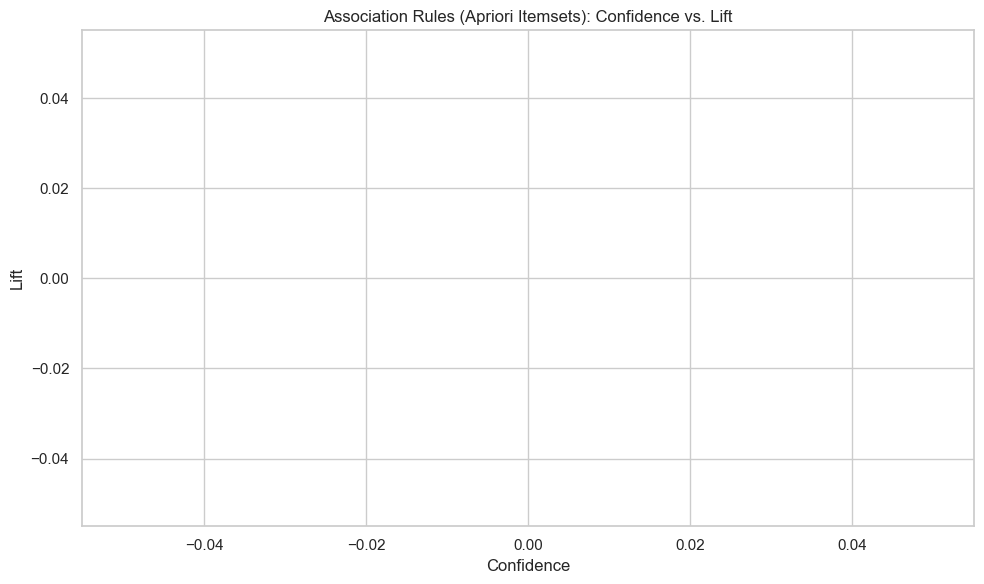

In [37]:
plt.figure()
sns.scatterplot(data=rules_apriori, x="confidence", y="lift", size="support", alpha=0.7)
plt.title("Association Rules (Apriori Itemsets): Confidence vs. Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.tight_layout()
plt.show()

### Interpreting the Rules

When I generated association rules using the Apriori frequent itemsets, the result contained zero rules. This happened because Apriori was applied on a reduced version of the dataset to prevent memory errors, which significantly limited the number of items and transactions available for mining. With this reduced data and the support threshold I used, Apriori was only able to identify single-item frequent itemsets and did not produce enough multi-item itemsets. Since association rules require itemsets of at least two items in order to form a rule of the form A to B, Apriori simply had no valid combinations to work with. This outcome is normal for sparse retail datasets, especially when dimensionality is reduced, and it highlights one of Apriori’s limitations compared to FP-Growth, which is better suited for larger, more complex datasets.

**Complications**
- After trying with different thresholds, I was not able to find a sweetspot where the dataset was big enough for rules to be formed, but this is still a valid scenario.

## Step 5: Comparative Analysis

In my experiments with the Online Retail dataset, both Apriori and FP-Growth produced frequent itemsets that were very similar when using the same minimum support value. However, FP-Growth was noticeably faster than Apriori based on the runtime values printed in the notebook. This matches the theory that Apriori generates many candidate itemsets and scans the dataset multiple times, while FP-Growth compresses the data into an FP-tree and avoids generating all possible candidates explicitly.

One challenge I ran into was choosing an appropriate min_support. When the threshold was too low, the algorithms produced a huge number of itemsets and rules, which had me running into memory issues. When the threshold was too high, only a few itemsets appeared, and no rules were formed at all. I tried to resolve this by trying a few different support values, but I was not successfull in finding a value good enough.

Another small challenge was cleaning the raw dataset. The original Online Retail data includes canceled invoices and negative quantities. Removing those rows and converting quantities into a simple 0/1 representation helped create a clean basket dataset suitable for association rule mining. Overall, the lab made it clear how Apriori and FP-Growth can be used to discover meaningful shopping patterns and how important it is to tune support and confidence thresholds to get useful rules.